In [1]:
# Jax imports
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit
from jax import config
config.update("jax_enable_x64", False)

In [2]:
from matplotlib import pyplot as plt

In [3]:
# IO utils
from jax_2dtm.io import load_grid_as_cloud

In [4]:
# Image simulator
from jax_2dtm.simulator import rotate_and_translate, project
from jax_2dtm.simulator import Cloud, Pose, ImageConfig
from jax_2dtm.utils import ifft

In [5]:
# Volume filename and metadata
pixel_size = 6.6 # Angstroms
filename = "../tests/data/example.mrc"

In [6]:
# Configure image data and read template as point cloud
config = ImageConfig((54, 54), pixel_size, eps=1e-6)
cloud = load_grid_as_cloud(filename, config, threshold=1e-5)

In [7]:
# Transform coordinates
pose = Pose(np.pi/8, np.pi/2, 0.0, 30.0, 70.0)
transformed_cloud = rotate_and_translate(cloud, pose)

In [8]:
# Compute scattering image
scattering_image = project(transformed_cloud, config)

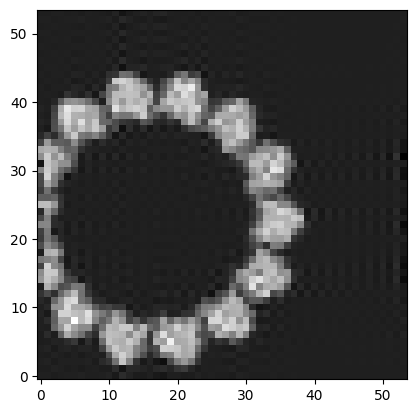

In [9]:
# Plot scattering image
plt.imshow(ifft(scattering_image), origin="lower", cmap="gray")

In [10]:
def get_pipeline(config: ImageConfig, cloud: Cloud):
    """
    Get jitted pipeline with configured
    static variables.
    """

    def pipeline(phi, theta, psi, tx, ty):
        pose = Pose(phi, theta, psi, tx, ty)
        transformed_cloud = rotate_and_translate(cloud, pose)
        scattering_image = project(transformed_cloud, config)

        return scattering_image

    return pipeline
    


In [11]:
# Get pipeline
pipeline = get_pipeline(config, cloud)
jitted_pipeline = jax.jit(jax.vmap(pipeline, in_axes=0))# in_axes=[0, 0, 0, 0, 0, None, None]))

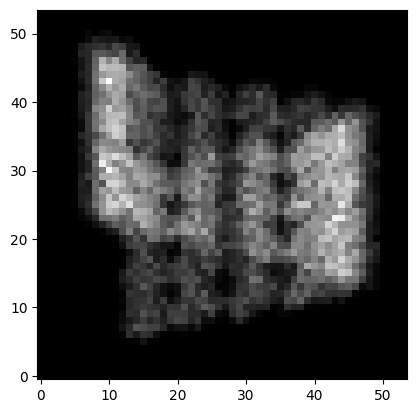

In [12]:
# Compute and plot
pose = Pose(np.array([np.pi/8, 0.0]), np.array([np.pi/2, 0]), np.array([0.0, 0.0]), np.array([30.0, 0.0]), np.array([70.0, 0.0]))
scattering_image = jitted_pipeline(*pose.iter_data())
plt.imshow(ifft(scattering_image[1]), origin="lower", cmap="gray")